In [2]:
pip install -q tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 69.0 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8O099B/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8O099B/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [6]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [9]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

cnn_model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
    callbacks=[es],
)

Epoch 1/5
391/391 [==============================] - 25s 10ms/step - loss: 1.6724 - accuracy: 0.3891 - val_loss: 1.4257 - val_accuracy: 0.4781
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 1.3224 - accuracy: 0.5251 - val_loss: 1.2173 - val_accuracy: 0.5651
Epoch 3/5
391/391 [==============================] - 3s 6ms/step - loss: 1.1663 - accuracy: 0.5878 - val_loss: 1.1564 - val_accuracy: 0.5945
Epoch 4/5
391/391 [==============================] - 3s 7ms/step - loss: 1.0578 - accuracy: 0.6292 - val_loss: 1.0143 - val_accuracy: 0.6459
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 0.9789 - accuracy: 0.6581 - val_loss: 1.0593 - val_accuracy: 0.6277


4/4 [==============================] - 0s 4ms/step


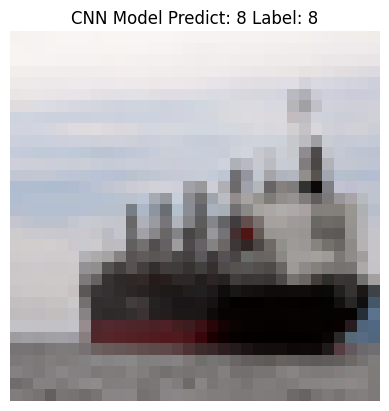

In [ ]:
first_element = ds_train.take(1)

import random
for image, label in first_element:

    random_num = random.randint(0,128)
    img = image[random_num]
    lb = label[random_num]

    cnn_predict = cnn_model.predict(image)
    cnn_predict = cnn_predict[random_num]
    cnn_predict = np.argmax(cnn_predict)
    
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.title('CNN Model Predict: {} Label: {}'.format(cnn_predict, lb.numpy()))
    plt.axis('off')
    plt.show()
    break

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def draw_confusion_matrix(model):
  # 테스트 데이터셋의 예측 수행
  y_pred = np.argmax(model.predict(ds_test), axis=-1)
  y_true = np.concatenate([y for _, y in ds_test], axis=0)

  # Confusion matrix 계산
  confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

  # Confusion matrix 시각화
  plt.imshow(confusion_matrix, cmap='Blues')
  plt.colorbar()
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()


79/79 [==============================] - 0s 2ms/step


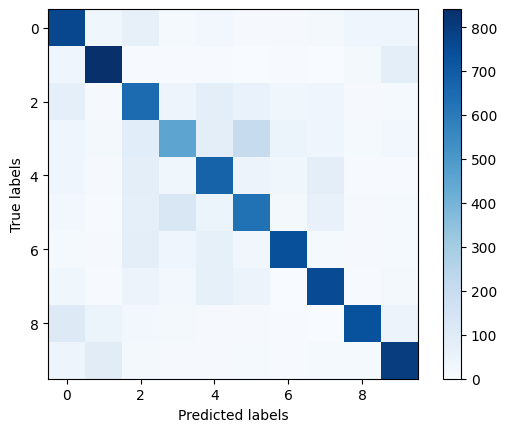

In [ ]:
draw_confusion_matrix(cnn_model)

# Resnet-18

In [ ]:
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)

resnet_model.trainable = False

model = tf.keras.models.Sequential([
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=[es]
)


94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/100
391/391 [==============================] - 13s 23ms/step - loss: 2.1171 - accuracy: 0.2269 - val_loss: 1.9599 - val_accuracy: 0.3001
Epoch 2/100
391/391 [==============================] - 7s 19ms/step - loss: 1.9439 - accuracy: 0.2944 - val_loss: 1.9041 - val_accuracy: 0.2977
Epoch 3/100
391/391 [==============================] - 7s 18ms/step - loss: 1.8719 - accuracy: 0.3252 - val_loss: 1.8219 - val_accuracy: 0.3510
Epoch 4/100
391/391 [==============================] - 8s 19ms/step - loss: 1.8290 - accuracy: 0.3424 - val_loss: 1.8148 - val_accuracy: 0.3566
Epoch 5/100
391/391 [==============================] - 7s 18ms/step - loss: 1.8067 - accuracy: 0.3511 - val_loss: 1.7760 - val_accuracy: 0.3678
Epoch 6/100
391/391 [==============================] - 8s 19ms/step - loss: 1.7794 - accuracy: 0.3639 - val_loss: 1.7662 - val_accuracy: 0.3685
Epoch 7/100
391/391 [==============================] - 7s 18ms/step - 

In [11]:
cnn_modelV2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.2),
    # tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.4),

    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax'),

    


    # tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    # tf.keras.layers.MaxPooling2D((2,2)),
    # tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation(activation='relu'),

    # tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    # tf.keras.layers.MaxPooling2D((2,2)),
    # tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation(activation='relu'),

    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.Activation(activation='relu'),


    # tf.keras.layers.Dense(10),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.Activation(activation='softmax'),
])

cnn_modelV2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

cnn_modelV2.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=[es],
)

Epoch 1/100
391/391 [==============================] - 18s 27ms/step - loss: 1.6971 - accuracy: 0.3902 - val_loss: 3.3106 - val_accuracy: 0.1850
Epoch 2/100
391/391 [==============================] - 10s 24ms/step - loss: 1.2044 - accuracy: 0.5712 - val_loss: 1.0086 - val_accuracy: 0.6423
Epoch 3/100
391/391 [==============================] - 9s 23ms/step - loss: 0.9860 - accuracy: 0.6543 - val_loss: 0.9655 - val_accuracy: 0.6620
Epoch 4/100
391/391 [==============================] - 9s 24ms/step - loss: 0.8514 - accuracy: 0.7045 - val_loss: 0.8281 - val_accuracy: 0.7233
Epoch 5/100
391/391 [==============================] - 9s 23ms/step - loss: 0.7547 - accuracy: 0.7399 - val_loss: 0.6791 - val_accuracy: 0.7629
Epoch 6/100
391/391 [==============================] - 9s 24ms/step - loss: 0.6896 - accuracy: 0.7634 - val_loss: 0.7073 - val_accuracy: 0.7649
Epoch 7/100
391/391 [==============================] - 10s 25ms/step - loss: 0.6314 - accuracy: 0.7858 - val_loss: 0.7462 - val_accura

79/79 [==============================] - 1s 6ms/step


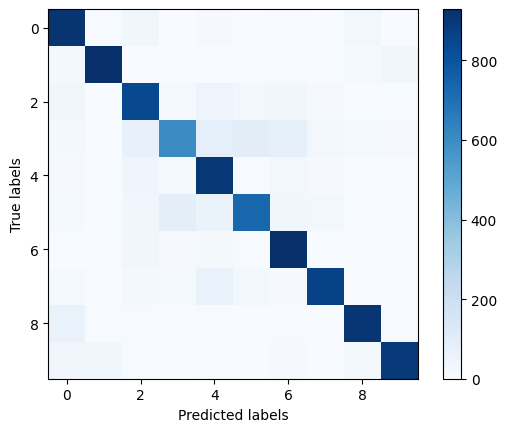

In [12]:
draw_confusion_matrix(cnn_modelV2)